## Lending Club loan analysis
This notebook looks at data from the Lending Club database. The database and csv file containing all loan info and data dictionary were obtained from a Kaggle link (https://www.kaggle.com/wendykan/lending-club-loan-data). This database contains informatiing relating to loans given from 2008 to 2015.
* **Section 1:<br>Exploratory analyses** is done to look at general features such as *average loan*, *interest rate* and *intallments* over time, *loan purposes* and *amounts* and *status* of loans. This is done in **SQL** and output files of the SQL query results are used here.<br>
* **Section 2:<br> Only good and bad loans will be examined** (based on information for loan status from above. Also done in **SQL** and output files of the SQL query results are used here.<br>
Good and bad loans will be *stratified* by loan grade, US states the loans come from, loan amount, employment length, income, home ownership and installment. This is to examine if there are trends between type of loan and these features.<br>
For good/bad loans by states, the maps appear when viewed on NBViewer (https://nbviewer.jupyter.org/github/manieshablakey/loan-assessment-model/blob/master/loan-credit.ipynb) even if it may not appear on github.
* **Section 3:<br> Features selection:** look through all columns and determine which features will need to be kept for the loan prediction model. Those that contain information from the future/ not relevant will be removed.<br>
* **Section 4:<br> Data cleaning:** Convert catgorical variables to integers. Remove rows with missing values.<br> 
* **Section 5:**<br> **Machine Learning models: 2 models** are used to make predictions:<br> **1) K-Nearest Neighbors model** <br> **2) Logistic Regression model.**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

import folium as folium
import os
import seaborn as sns

### Section 1: Exploratory analyses

Look at total records in the database.

In [2]:
total= pd.read_csv("output/tot.csv")
tot = total["total records"][0]
print("The total number of records in the database is: {}.".format(tot))

The total number of records in the database is: 887383.


Look at the trends in average loan amount and average interest from 2008 to 2015.
From 2008-09 and around 2012-2013, even though average interest rates were increasing, average loan amounts were also high/increasing.  


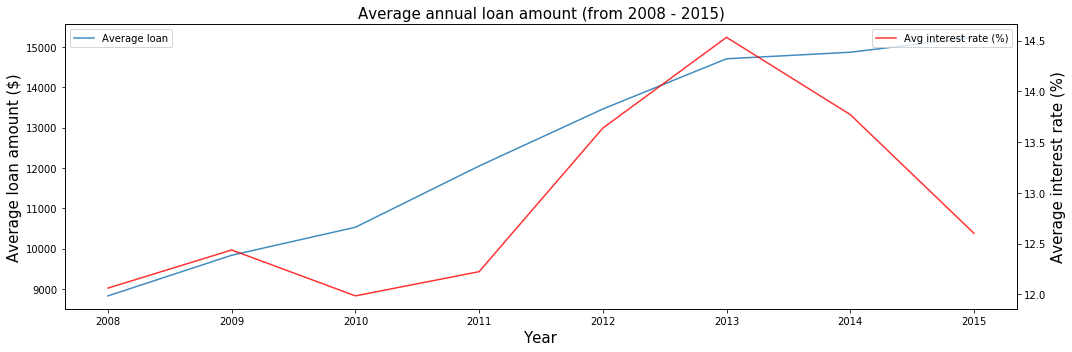

In [3]:
# average loan.
loan_month = pd.read_csv("output/avg-loan.csv")
xmonth = loan_month["loan_year"]
yavg_loan = loan_month["average_loan"]
month_cat = np.arange(len(xmonth))

# average interest.
int_month = pd.read_csv("output/avg-interest.csv")
yavg_int = int_month["interest_rate"]
month_cat = np.arange(len(xmonth))

# plot figure
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(111)

# figure for avg loan.
ax1.set_xlabel("Year",fontsize=15)
ax1.set_ylabel("Average loan amount ($)",fontsize=15)
ax1.set_title("Average annual loan amount (from 2008 - 2015)",fontsize=15)
ax1.plot(xmonth, yavg_loan, alpha=0.85, label="Average loan")

# figure for avg interest.
ax2 = ax1.twinx()
ax2.set_ylabel("Average interest rate (%)",fontsize=15)
ax2.plot(xmonth, yavg_int, alpha=0.8, 
         label="Avg interest rate (%)",
         color="red")

ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

fig.tight_layout()
plt.show()

Look at trends in average loan installment from 2008 to 2015. This has increased from around $275/month is 2008 to around $425 in 2015.

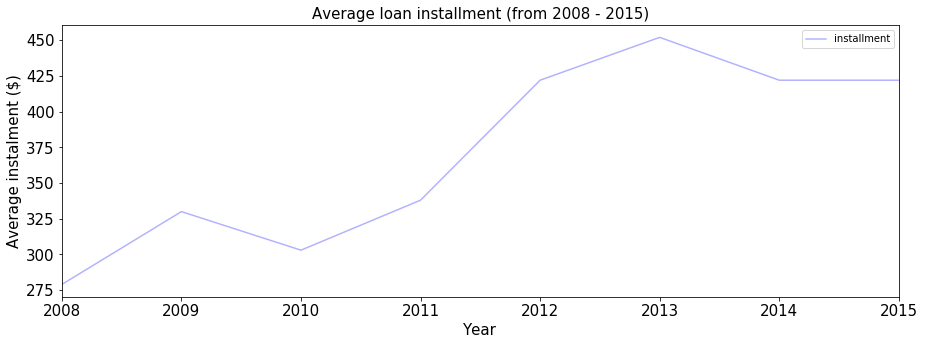

In [4]:
# avg installment
install = pd.read_csv("output/avg-installment.csv")
avg_instal = pd.DataFrame({"loan_year": [2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015], 
                           "installment": [279.0, 330.0, 303.0, 338.0, 422.0, 452.0, 422.0, 422.0]})
avg_instal.plot(kind="line", x="loan_year", y="installment", color="b", alpha=0.3, figsize=(15,5), fontsize=15)

plt.xlabel('Year', fontsize=15)
plt.ylabel('Average instalment ($)', fontsize=15)
plt.title('Average loan installment (from 2008 - 2015)', fontsize=15)
plt.show()

What are the loans used for? We can see that the bulk of it is used for debt consolidation, followed by credit card payments.

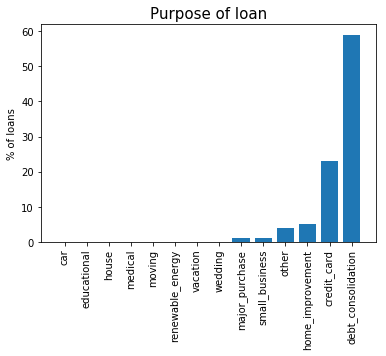

In [5]:
# loan purpose
purpose = pd.read_csv("output/purpose.csv")
x_purpose = purpose["purpose"]
y_perct = purpose["Percentage"]
purpose_cat = np.arange(len(x_purpose))
plt.bar(x_purpose, y_perct)
plt.xticks(purpose_cat, x_purpose, rotation=90)
plt.ylabel("% of loans")
plt.title("Purpose of loan", fontsize=15)
plt.show()

Categorize loan amounts into 4 categorize to see what are the most common loan amounts give. 
Most loans re between $5000- $15000.

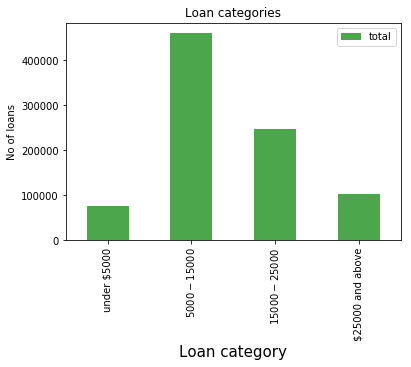

In [6]:
# loan categories
lf = pd.read_csv("output/loan-cat.csv")
lf = pd.DataFrame({"loan_amount": [1, 2, 3, 4], "total" : [75513, 460027, 248174, 103669]})
lf["loan_amount"] = lf["loan_amount"].replace({1: "under $5000", 2: "$5000 - $15000", 3: "$15000 - $25000", 4: "$25000 and above"})
lf.plot(kind="bar", x="loan_amount", y="total", color="g", alpha=0.7)
plt.xlabel('Loan category', fontsize=15)
plt.ylabel('No of loans')
plt.title('Loan categories')
plt.show()

What is the distribution of loan status of all loans in the database? Most are current loans (> 600,00).

In [7]:
# loan distribution
loan_type = pd.read_csv("output/loan-status-overall.csv")
loan_type

,loan_status,No of loans
0,Does not meet the credit policy. Status:Charge...,761
1,Default,1219
2,Does not meet the credit policy. Status:Fully ...,1988
3,Late (16-30 days),2357
4,In Grace Period,6253
5,Issued,8460
6,Late (31-120 days),11591
7,Charged Off,45248
8,Fully Paid,207724
9,Current,601781


### Section 2: Exploratory analyses stratified by good/bad loans.
For the rest of the analyses in this notebook, loans will be categorized as follows:
- Good loans (this will be made up of fully paid loans).
- Bad loans (will consist of charged off loans. 
- Remaining will not be taken into account as they are either current or there isn't enought information to determine status.
- To get a better sense of what determines if a loan will be paid off or not, we will look at the good/bad loans only.

In [8]:
# good/bad loan and numbers
loan_type = pd.read_csv("output/loan-status.csv")
print("No of bad loans and good loans, respectively:")
loan_type

No of bad loans and good loans, respectively:


,loan_status,number
0,Charged Off,45248
1,Fully Paid,207724


Total number of good & bad loans, from the above and plotted as a pie chart in %. We can see that >80% of loans are good loans.

The total number of good & bad loans is: 252972.


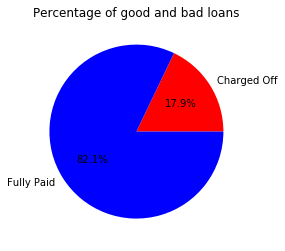

In [9]:
loan_status_tot = loan_type["number"].sum()
print("The total number of good & bad loans is: {}.".format(loan_status_tot))

# % good/bad loans.
values = [45248, 207724]
colors = ["r", "b"]
labels = ["Charged Off", "Fully Paid"]
plt.pie(values, colors=colors, labels=labels, autopct="%0.1f%%")
plt.title("Percentage of good and bad loans")
plt.show()

Dollar value of bad and good loans

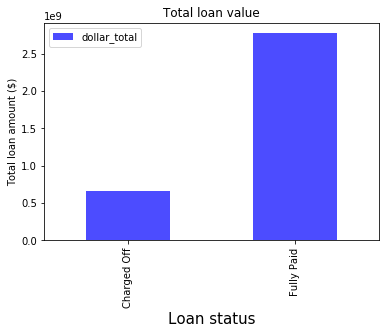

In [10]:
# total loan value for each type.
loan_val = pd.read_csv("output/loans-total.csv")
loan_val.plot(kind="bar", x="loan_status", y="dollar_total", color="b", alpha=0.7)

plt.xlabel('Loan status', fontsize=15)
plt.ylabel('Total loan amount ($)')
plt.title('Total loan value')
plt.show()

Good and bad loans by loan grade. Most good loans range from grade A to C. Most bad loans range from grade B to D.

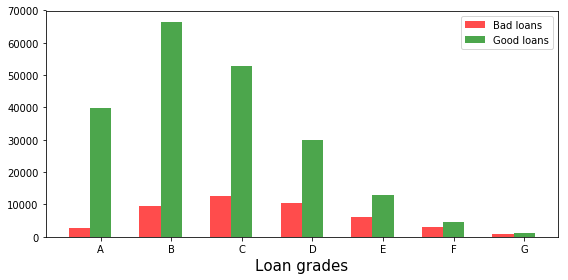

In [11]:
# loan type by loan grade.
lg = pd.read_csv("output/loans-grade.csv")
# loan_grade

# set width of bar
barWidth = 0.3
fig = plt.figure(figsize=(8, 4))

# set height of bar
xgrade = lg["grade"].drop_duplicates()
y_bad = lg[lg["loan_status"]== "Charged Off"]["loans number"]
y_good = lg[lg["loan_status"] == "Fully Paid"]["loans number"]

# Set position of bar on X axis
r1 = np.arange(len(xgrade))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
 
# Make the plot
plt.bar(r1, y_bad, color="r", alpha=0.7, width=barWidth, label="Bad loans")
plt.bar(r2, y_good, color="g", alpha=0.7, width=barWidth, label="Good loans")
 
# Add xticks on the middle of the group bars
plt.xlabel("Loan grades", fontsize=15)
plt.xticks([r + barWidth for r in range(len(xgrade))], ["A", "B", "C", "D", "E", "F", "G"])
 
# Create legend & Show graphic
plt.legend()
fig.tight_layout()
plt.show()

From above, we see that the majority of good/bad loans fall into grades A to D. Therefore, we will look at grade A to D to see what the main purposes of taking loans are. Again, the main reason across all 4 grades is for debt consolidation, followed by credit card payment.

/usr/local/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


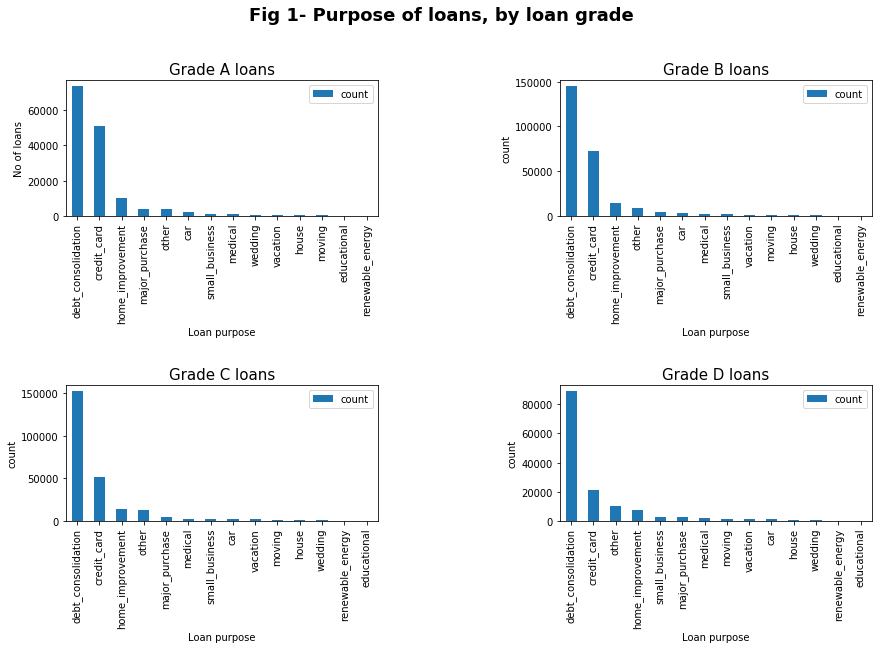

In [12]:
# loan purpose, by grade.
# Setting up a figure to accomodate 4 grades given in the dataset. 
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
fig.suptitle("Fig 1- Purpose of loans, by loan grade", fontweight="bold", size=18)

# Grade A loans, by purpose.
gp_a = pd.read_csv("output/grade-a-purpose.csv")
gp_a.plot(kind="bar", ax=axes[0,0], x="purpose", y="count")
axes[0,0].set_title("Grade A loans", fontsize=15)
axes[0,0].set_xlabel("Loan purpose")
axes[0,0].set_ylabel("No of loans")

# Grade B loans, by purpose.
gp_b = pd.read_csv("output/grade-b-purpose.csv")
gp_b.plot(kind="bar", ax=axes[0,1], x="purpose", y="count")
axes[0,1].set_title("Grade B loans", fontsize=15)
axes[0,1].set_xlabel("Loan purpose")
axes[0,1].set_ylabel("count")

# Grade C loans, by purpose.
gp_c = pd.read_csv("output/grade-c-purpose.csv")
gp_c.plot(kind="bar", ax=axes[1,0], x="purpose", y="count")
axes[1,0].set_title("Grade C loans", fontsize=15)
axes[1,0].set_xlabel("Loan purpose")
axes[1,0].set_ylabel("count")

# Grade D loans, by purpose.
gp_d = pd.read_csv("output/grade-d-purpose.csv")
gp_d.plot(kind="bar", ax=axes[1,1], x="purpose", y="count")
axes[1,1].set_title("Grade D loans", fontsize=15)
axes[1,1].set_xlabel("Loan purpose")
axes[1,1].set_ylabel("count")

fig.tight_layout(pad=7, w_pad=12, h_pad=3)
fig.show()

Next, we'll look at the distribution of good loans across US states. The map describes the number of loans. We can see from the figure below that the highest number of good loans come from California. This is followed by Texas, Florida and New York. These are also the 4 most populous states in the US. 

In [13]:
# map loads when viewed with nbviewer (https://nbviewer.jupyter.org/github/manieshablakey/loan-assessment-model/blob/master/loan-credit.ipynb)
# good loans by state
good_loans_state = pd.read_csv("output/good-loans-state.csv")

# Vol of loans by state.
# load map shape (US states)
state_geo = os.path.join("data", "us-states.json")

# load loan data for each state
df = os.path.join("output", "good-loans-state.csv")
good_loans = pd.read_csv(df)

# initialize map
m = folium.Map(location=[37, -102], zoom_start=4)

# set parameters for map, add color.
folium.Choropleth(
    geo_data=state_geo,
    name="choropleth",
    data=good_loans,
    columns=["addr_state", "loans_vol"],
    key_on="feature.id",
    fill_color="BuGn",
    fill_opacity=0.8,
    line_opacity=0.3,
    legend_name="No of good loans"
).add_to(m)
folium.LayerControl().add_to(m)
m

# # Save to html
# m.save("good_loans_map.html")

Let's look at the distribution of bad loans across US states. The map describes the number of loans. We can see from the figure below that the highest number of bad loans come from California. Next is New York state. This is followed by Texas and Florida.

In [14]:
# map loads when viewed with nbviewer (https://nbviewer.jupyter.org/github/manieshablakey/loan-assessment-model/blob/master/loan-credit.ipynb)
# bad loans by state
bad_loans_state = pd.read_csv("output/bad-loans-state.csv")

# Vol of loans by state.
# load map shape (US states)
state_geo = os.path.join("data", "us-states.json")

# load loan data for each state
dl = os.path.join("output", "bad-loans-state.csv")
bad_loans = pd.read_csv(dl)

# initialize map
m = folium.Map(location=[37, -102], zoom_start=4)

# set parameters for map, add color.
folium.Choropleth(
    geo_data=state_geo,
    name='choropleth',
    data=bad_loans,
    columns=['addr_state', 'loans_vol'],
    key_on='feature.id',
    fill_color='RdPu',
    fill_opacity=0.8,
    line_opacity=0.3,
    legend_name='No of bad loans'
).add_to(m)
folium.LayerControl().add_to(m)
m

# # Save to html
# m.save("bad_loans_map.html")

Bulk of good & bad loans both come from 5000 to 25000 dollar category.

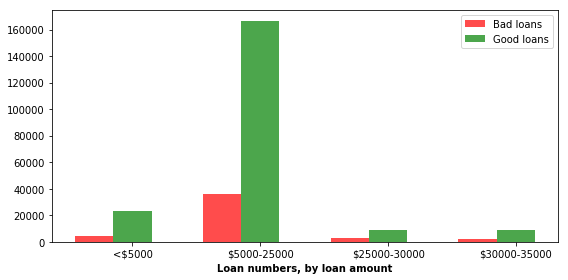

In [15]:
# loan amount by loan status
ls = pd.read_csv("output/loan-status-amount.csv")
ls = ls.reindex(index = [3, 2, 0, 1, 7, 6, 4, 5])

# set width of bar
barWidth = 0.3
fig = plt.figure(figsize=(8, 4))

# set height of bar
x_grade = ls["loans"].drop_duplicates()
y_bad = ls[ls["loan_status"] == "Charged Off"]["total"]
y_good = ls[ls["loan_status"] == "Fully Paid"]["total"]

# Set position of bar on X axis
r1 = np.arange(len(x_grade))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
 
# Make the plot
plt.bar(r1, y_bad, color="r", alpha=0.7, width=barWidth, label="Bad loans")
plt.bar(r2, y_good, color="g", alpha=0.7, width=barWidth, label="Good loans")
 
# Add xticks on the middle of the group bars
plt.xlabel("Loan numbers, by loan amount", fontweight="bold")
plt.xticks([r + barWidth for r in range(len(x_grade))], ["<$5000", "$5000-25000", "$25000-30000", "$30000-35000"])
 
# Create legend & Show graphic
plt.legend()
fig.tight_layout()
plt.show()

Looking at the employment lengths of those with good loans and bad loans, we see that the trends are very similar, with the majority in > 10 years of employment across both loan categories.

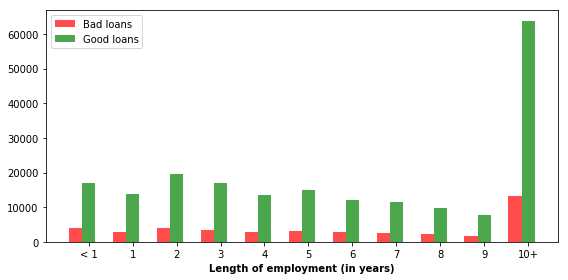

In [16]:
# employment length by loan type
el = pd.read_csv("output/employment-loan.csv")
el = el.reindex(index = [10, 0, 2, 3, 4, 5, 6, 7, 8, 9, 1, 21, 11, 13, 14, 15, 16, 17, 18, 19, 20, 12])

# set width of bar
barWidth = 0.3
fig = plt.figure(figsize=(8, 4))

# set height of bar
x_length = el["emp_length"].drop_duplicates()
y_bad = el[el["loan_status"] == "Charged Off"]["number"]
y_good = el[el["loan_status"] == "Fully Paid"]["number"]

# Set position of bar on X axis
r1 = np.arange(len(x_length))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
 
# Make the plot
plt.bar(r1, y_bad, color="r", alpha=0.7, width=barWidth, label="Bad loans")
plt.bar(r2, y_good, color="g", alpha=0.7,width=barWidth, label="Good loans")
 
# Add xticks on the middle of the group bars
plt.xlabel("Length of employment (in years)", fontweight="bold")
plt.xticks([r + barWidth for r in range(len(x_length))], ["< 1", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10+"])
 
# Create legend & show graph
plt.legend()
fig.tight_layout()
plt.show()

When we look at income levels by loan time, the patterns are also similar, with the most loans in both loan types given to those with an annual income between 50,000 and 100,000 dollars.

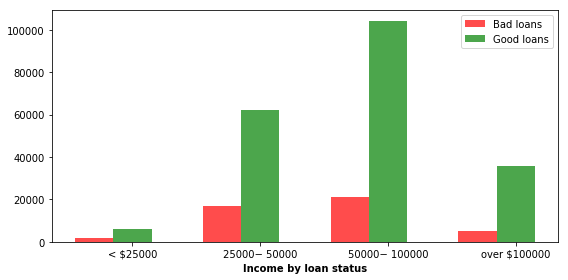

In [17]:
# income by loan type
li = pd.read_csv("output/income-loan.csv")
li = li.reindex(index = [2, 0, 1, 3, 6, 4, 5, 7])

# set width of bar
barWidth = 0.3
fig = plt.figure(figsize=(8,4))

# set height of bar
x_length = li["income"].drop_duplicates()
y_bad = li[li["loan_status"] == "Charged Off"]["total"]
y_good = li[li["loan_status"] == "Fully Paid"]["total"]

# set position of bar on X asia
r1 = np.arange(len(x_length))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
 
# Make the plot
plt.bar(r1, y_bad, color="r", alpha=0.7, width=barWidth, label="Bad loans")
plt.bar(r2, y_good, color="g", alpha=0.7, width=barWidth, label="Good loans")
 
# Add xticks on the middle of the group bars
plt.xlabel("Income by loan status", fontweight="bold")
plt.xticks([r + barWidth for r in range(len(x_length))], ["< $25000", "25000− 50000", "50000− 100000", "over $100000"])
 
# Create legend & Show graphic
plt.legend()
fig.tight_layout()
plt.show()

Looking at home ownership, we see that the majority of those with good loans have a mortgage on their homes. The majority of those with bad loans are tied between those with mortgages and renters.

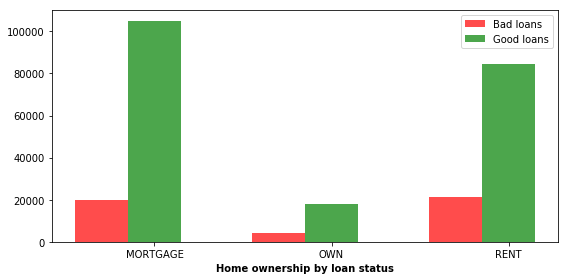

In [18]:
# home ownership by loan type
lh = pd.read_csv("output/home-loan.csv")

# set width of bar
barWidth = 0.3
fig = plt.figure(figsize=(8, 4))

# set height of bar
x_length = lh["home_ownership"].drop_duplicates()
y_bad = lh[lh["loan_status"] == "Charged Off"]["total"]
y_good = lh[lh["loan_status"] == "Fully Paid"]["total"]

# Set position of bar on X axis
r1 = np.arange(len(x_length))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
 
# Make the plot
plt.bar(r1, y_bad, color="r", alpha=0.7, width=barWidth, label="Bad loans")
plt.bar(r2, y_good, color="g", alpha=0.7, width=barWidth, label="Good loans")
 
# Add xticks on the middle of the group bars
plt.xlabel("Home ownership by loan status", fontweight="bold")
plt.xticks([r + barWidth for r in range(len(x_length))], ["MORTGAGE", "OWN", "RENT"])
 
# Create legend & Show graphic
plt.legend()
fig.tight_layout()
plt.show()

The trends between installment amounts and loan type are very similar across both categories. Most installments are between $250-$500 for each category.

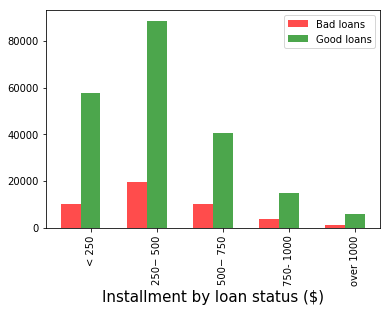

In [19]:
# installment by loan type
inst = pd.read_csv("output/loan-installment.csv")
inst = inst.reindex( index = [3, 0, 1, 2, 4, 8, 5, 6, 7, 9])
inst

# set width of bar
barWidth = 0.3
fig = plt.figure(figsize=(6, 4))

# set height of bar
bars1 = [10155, 19631, 10163, 3896, 1403]
bars2 = [57603, 88509, 40555, 15140, 5917]

# set position of bar on X asia
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
# Make the plot
plt.bar(r1, bars1, color="r", alpha=0.7, width=barWidth, label="Bad loans")
plt.bar(r2, bars2, color="g", alpha=0.7, width=barWidth, label="Good loans")
 
# Add xticks on the middle of the group bars
plt.xlabel("Installment by loan status ($)", fontsize=15)
plt.xticks([r + barWidth for r in range(len(bars1))], ["< 250", "250− 500", "500− 750", "750- 1000", "over 1000"], rotation=90)
 
# Create legend & Show graphic
plt.legend()
plt.show()

### Section 3: Features selection
In this section, we look at all columns in the dataset to determine if the features will be relevant/useful to predict loan status outcome. Those that are not useful or contain information from the future (after loans have been assigned) will be removed from the dataset.

In [20]:
df = pd.read_csv("data/loan.csv", low_memory=False)
half_count = len(df) / 2

# Drop columns with > 50% missing values.
df = df.dropna(thresh=half_count, axis=1)

# Drop the following column which which does not provide useful 
df = df.drop(["url"], axis=1)

# Now, look at first 5 rows of dataset.
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,...,171.62,NaN,Jan-2016,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,...,119.66,NaN,Sep-2013,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,...,649.91,NaN,Jan-2016,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN
3,1076863,1277178,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,...,357.48,NaN,Jan-2015,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN
4,1075358,1311748,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,B5,...,67.79,Feb-2016,Jan-2016,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN


In [21]:
# look at shape of data. There are 887,379 rows and 52 columns in the current dataset.
df.shape

(887379, 52)

In [22]:
# These are all the column names. 
# The LCDataDictionary file has been provided in the data folder and gives a description of each column.
df.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'issue_d', 'loan_status', 'pymnt_plan', 'purpose', 'title', 'zip_code',
       'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
       'total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv',
       'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'policy_code', 'application_type',
       'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim'],
      dtype='object')

Each column needs to be examined to determine if it is useful to be kept in the dataset. To do this, the columns are divided into groups. For each group, every column will be compared to column dictionary to see what it represents. If they contain information that is not useful or obtained only after loans are assigned, they are removed from the dataset as such features will not contribute to a loan outcome prediction model. 

In [23]:
# First 20 columns.
df.iloc[:, :20].head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,purpose,title
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-2011,Fully Paid,n,credit_card,Computer
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-2011,Charged Off,n,car,bike
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-2011,Fully Paid,n,small_business,real estate business
3,1076863,1277178,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.0,Source Verified,Dec-2011,Fully Paid,n,other,personel
4,1075358,1311748,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,B5,University Medical Group,1 year,RENT,80000.0,Source Verified,Dec-2011,Current,n,other,Personal


From the above, the following columns are removed are the information they provide is not useful/redundant:
id, member_id, sub_grade(grade info has been kept),int_rate (grade info has accounted for this), emp_title, issue_d and title (purpose is kept).
These columns are also removed as they contain information from after loans are given: funded_amt & funded_amt_inv

In [24]:
# remove the following columns.
drop_cols1 = ['id','member_id','funded_amnt','funded_amnt_inv',
             'int_rate','sub_grade','emp_title','issue_d']
df = df.drop(drop_cols1,axis=1)

After the above columns are dropped, we look at the remaining columns. 
Looking at the table below, zip_code column is dropped as the information given is not useful (we have state names). All other columns below are dropped as they contain future info that is not valuable for a loan outcome prediction model.

In [25]:
# next lot of columns
df.iloc[50:60, 19:38].head()

,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med
50,0.0,11845.0,63.7,28.0,f,0.0,0.0,16177.770000,16177.77,13556.45,2374.34,24.17,222.81,36.3708,Oct-2014,483.38,NaN,Mar-2015,0.0
51,0.0,26088.0,62.0,27.0,f,0.0,0.0,29695.622676,29405.63,25600.00,4095.62,0.00,0.00,0.0000,Jan-2015,838.27,NaN,Jan-2016,0.0
52,0.0,12168.0,92.9,12.0,f,0.0,0.0,8205.473816,8205.47,7000.00,1205.47,0.00,0.00,0.0000,Jan-2015,240.27,NaN,Dec-2014,0.0
53,0.0,15793.0,90.8,11.0,f,0.0,0.0,3521.950000,3521.95,1903.66,1039.35,0.00,578.94,5.4900,Aug-2012,421.65,NaN,Dec-2012,0.0
54,0.0,12143.0,52.1,12.0,f,0.0,0.0,13748.213110,13748.21,12000.00,1748.21,0.00,0.00,0.0000,Jul-2014,964.73,NaN,Jul-2014,0.0


In [26]:
# remove the following columns.
drop_cols2 = [ 'zip_code','out_prncp','out_prncp_inv',
             'total_pymnt','total_pymnt_inv', 'delinq_2yrs', 'initial_list_status']
df = df.drop(drop_cols2, axis=1)

drop_cols3 = ['total_rec_prncp','total_rec_int', 'total_rec_late_fee',
             'recoveries', 'collection_recovery_fee', 'last_pymnt_d',
             'last_pymnt_amnt']
df = df.drop(drop_cols3, axis=1)

Since dataset column numbers changed between the first drop of columns and the second, take a look at the remaining columns to see if there are others that need to be removed.

In [27]:
df.columns

Index(['loan_amnt', 'term', 'installment', 'grade', 'emp_length',
       'home_ownership', 'annual_inc', 'verification_status', 'loan_status',
       'pymnt_plan', 'purpose', 'title', 'addr_state', 'dti',
       'earliest_cr_line', 'inq_last_6mths', 'open_acc', 'pub_rec',
       'revol_bal', 'revol_util', 'total_acc', 'next_pymnt_d',
       'last_credit_pull_d', 'collections_12_mths_ex_med', 'policy_code',
       'application_type', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal',
       'total_rev_hi_lim'],
      dtype='object')

Looking at the above columns remaining, we remove the following columns that future information/ info that is not useful.

In [28]:
# additional columns to drop
drop_cols4 = ['title', 'inq_last_6mths','next_pymnt_d', 'collections_12_mths_ex_med', 'policy_code', 'application_type',
             'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim']
df = df.drop(drop_cols4, axis=1)

In [29]:
df.head()

,loan_amnt,term,installment,grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,pymnt_plan,purpose,addr_state,dti,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,total_acc,last_credit_pull_d
0,5000.0,36 months,162.87,B,10+ years,RENT,24000.0,Verified,Fully Paid,n,credit_card,AZ,27.65,Jan-1985,3.0,0.0,13648.0,83.7,9.0,Jan-2016
1,2500.0,60 months,59.83,C,< 1 year,RENT,30000.0,Source Verified,Charged Off,n,car,GA,1.00,Apr-1999,3.0,0.0,1687.0,9.4,4.0,Sep-2013
2,2400.0,36 months,84.33,C,10+ years,RENT,12252.0,Not Verified,Fully Paid,n,small_business,IL,8.72,Nov-2001,2.0,0.0,2956.0,98.5,10.0,Jan-2016
3,10000.0,36 months,339.31,C,10+ years,RENT,49200.0,Source Verified,Fully Paid,n,other,CA,20.00,Feb-1996,10.0,0.0,5598.0,21.0,37.0,Jan-2015
4,3000.0,60 months,67.79,B,1 year,RENT,80000.0,Source Verified,Current,n,other,OR,17.94,Jan-1996,15.0,0.0,27783.0,53.9,38.0,Jan-2016


From the above dataframe, let's look at the unique instances of the payment plan feature

In [30]:
# pymnt_plan unique
pyment = df["pymnt_plan"].unique().tolist()

print("No of instances of y in pyment_plan: {}".format((df["pymnt_plan"]== "y").sum()))
print("No of instances of n in pyment_plan: {}".format((df["pymnt_plan"]== "n").sum()))

No of instances of y in pyment_plan: 10
No of instances of n in pyment_plan: 887369


There are too few instances of y compared to n to make meaningful inferences, in pymnt_plan columns. Therefore, it can be dropped.

In [31]:
df = df.drop("pymnt_plan", axis=1)

Take another look at the columns to make sure all are useful/do not contain future info.

In [32]:
df.columns

Index(['loan_amnt', 'term', 'installment', 'grade', 'emp_length',
       'home_ownership', 'annual_inc', 'verification_status', 'loan_status',
       'purpose', 'addr_state', 'dti', 'earliest_cr_line', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'last_credit_pull_d'],
      dtype='object')

#### Target variable: Loan status
The aim of the machine learning models are to predict good/bad loans. Therefore, loan status is the outcome variable.
From the exploratory analysis section above, we saw there were several categories of loans. For this model, we will only consider the "Fully Paid" (good) loans and "Charged Off" (bad) loans. We filter the dataset to only included these rows,

In [33]:
df = df[(df["loan_status"] == "Fully Paid") | (df["loan_status"] == "Charged Off")]
df["loan_status"].unique().tolist()

['Fully Paid', 'Charged Off']

From the features selected from the dataset, look at general statistics of numerical columns.

In [34]:
df.describe()

,loan_amnt,installment,annual_inc,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc
count,252971.000000,252971.000000,2.529710e+05,252971.000000,252971.000000,252971.000000,2.529710e+05,252772.000000,252971.000000
mean,13562.768855,418.112216,7.253825e+04,16.544104,10.939566,0.143439,1.516798e+04,54.312093,25.035905
std,8131.729531,244.933059,5.881181e+04,7.788696,4.890986,0.436383,1.874300e+04,24.790577,11.747131
min,500.000000,15.690000,3.000000e+03,0.000000,0.000000,0.000000,0.000000e+00,0.000000,2.000000
25%,7200.000000,239.550000,4.500000e+04,10.750000,7.000000,0.000000,5.862000e+03,36.300000,16.000000
50%,12000.000000,365.230000,6.200000e+04,16.200000,10.000000,0.000000,1.093700e+04,55.800000,23.000000
75%,18250.000000,547.550000,8.700000e+04,21.990000,14.000000,0.000000,1.906650e+04,73.900000,32.000000
max,35000.000000,1424.570000,8.706582e+06,57.140000,76.000000,15.000000,1.746716e+06,892.300000,150.000000


In [35]:
# save data.
df.to_csv("data/updated_loan_data.csv", index=False)

 ### Section 4: Data Cleaning
 Start by loading the dataset with relevant columns as saved above and take a look at the first 5 rows.

In [36]:
updated_loans = pd.read_csv("data/updated_loan_data.csv")
print(updated_loans.shape)
updated_loans.head()

(252971, 19)


,loan_amnt,term,installment,grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,addr_state,dti,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,total_acc,last_credit_pull_d
0,5000.0,36 months,162.87,B,10+ years,RENT,24000.0,Verified,Fully Paid,credit_card,AZ,27.65,Jan-1985,3.0,0.0,13648.0,83.7,9.0,Jan-2016
1,2500.0,60 months,59.83,C,< 1 year,RENT,30000.0,Source Verified,Charged Off,car,GA,1.00,Apr-1999,3.0,0.0,1687.0,9.4,4.0,Sep-2013
2,2400.0,36 months,84.33,C,10+ years,RENT,12252.0,Not Verified,Fully Paid,small_business,IL,8.72,Nov-2001,2.0,0.0,2956.0,98.5,10.0,Jan-2016
3,10000.0,36 months,339.31,C,10+ years,RENT,49200.0,Source Verified,Fully Paid,other,CA,20.00,Feb-1996,10.0,0.0,5598.0,21.0,37.0,Jan-2015
4,5000.0,36 months,156.46,A,3 years,RENT,36000.0,Source Verified,Fully Paid,wedding,AZ,11.20,Nov-2004,9.0,0.0,7963.0,28.3,12.0,Sep-2015


In [37]:
# Look at all the data types in the dataset.
updated_loans.dtypes

loan_amnt              float64
term                    object
installment            float64
grade                   object
emp_length              object
home_ownership          object
annual_inc             float64
verification_status     object
loan_status             object
purpose                 object
addr_state              object
dti                    float64
earliest_cr_line        object
open_acc               float64
pub_rec                float64
revol_bal              float64
revol_util             float64
total_acc              float64
last_credit_pull_d      object
dtype: object

In [38]:
# Look at all missing values in the dataset.
null_values = updated_loans.isnull().sum()
null_values

loan_amnt                 0
term                      0
installment               0
grade                     0
emp_length             9897
home_ownership            0
annual_inc                0
verification_status       0
loan_status               0
purpose                   0
addr_state                0
dti                       0
earliest_cr_line          0
open_acc                  0
pub_rec                   0
revol_bal                 0
revol_util              199
total_acc                 0
last_credit_pull_d       21
dtype: int64

In [39]:
# Drop rows with missing values
updated_loans = updated_loans.dropna()
updated_loans.isnull().sum()

loan_amnt              0
term                   0
installment            0
grade                  0
emp_length             0
home_ownership         0
annual_inc             0
verification_status    0
loan_status            0
purpose                0
addr_state             0
dti                    0
earliest_cr_line       0
open_acc               0
pub_rec                0
revol_bal              0
revol_util             0
total_acc              0
last_credit_pull_d     0
dtype: int64

#### Categorical variables
Take a look at any one row in the dataset to see how object variables are formatted.

In [40]:
obj_col = updated_loans.select_dtypes(include=["object"])
print(obj_col.iloc[5])

term                         36 months
grade                                E
emp_length                     9 years
home_ownership                    RENT
verification_status    Source Verified
loan_status                 Fully Paid
purpose                            car
addr_state                          CA
earliest_cr_line              Jan-2007
last_credit_pull_d            Dec-2014
Name: 5, dtype: object


Looking at this row, drop date value columns as these are not useful for the model. The columns are earliest_cr_line & last_credit_pull_d

In [41]:
drop_cols5 = ["earliest_cr_line", "last_credit_pull_d"]
updated_loans = updated_loans.drop(drop_cols5, axis=1)

In order to convert categorical variables into integers, let's first look at the unique instances for each of the categorical variables left.

In [42]:
term_unique = updated_loans["term"].unique()
grade_unique = updated_loans["grade"].unique()
emp_length_unique = updated_loans["emp_length"].unique()
home_own_unique = updated_loans["home_ownership"].unique()
ver_status_unique = updated_loans["verification_status"].unique()
loan_unique = updated_loans["loan_status"].unique()
purpose_unique = updated_loans["purpose"].unique()
add_state_unique = updated_loans["addr_state"].unique()

print("The unique instances of loan term are: {}".format(term_unique))
print("The unique instances of loan grades are: {}".format(grade_unique))
print("The unique instances of employment length are: {}".format(emp_length_unique))
print("The unique instances of home ownership are: {}".format(home_own_unique))
print("The unique instances of verification status are: {}".format(ver_status_unique))
print("The unique instances of loan status are: {}".format(loan_unique))
print("The unique instances of loan purpose are: {}".format(purpose_unique))
print("The unique instances of address state are: {}".format(add_state_unique))

The unique instances of loan term are: [' 36 months' ' 60 months']
The unique instances of loan grades are: ['B' 'C' 'A' 'E' 'F' 'D' 'G']
The unique instances of employment length are: ['10+ years' '< 1 year' '3 years' '9 years' '4 years' '5 years' '1 year'
 '6 years' '2 years' '7 years' '8 years']
The unique instances of home ownership are: ['RENT' 'OWN' 'MORTGAGE' 'OTHER' 'NONE' 'ANY']
The unique instances of verification status are: ['Verified' 'Source Verified' 'Not Verified']
The unique instances of loan status are: ['Fully Paid' 'Charged Off']
The unique instances of loan purpose are: ['credit_card' 'car' 'small_business' 'other' 'wedding'
 'debt_consolidation' 'home_improvement' 'major_purchase' 'medical'
 'moving' 'vacation' 'house' 'renewable_energy' 'educational']
The unique instances of address state are: ['AZ' 'GA' 'IL' 'CA' 'TX' 'VA' 'MO' 'CT' 'UT' 'FL' 'NY' 'PA' 'MN' 'NJ'
 'OR' 'KY' 'OH' 'SC' 'RI' 'LA' 'MA' 'WA' 'WI' 'AL' 'NV' 'AK' 'CO' 'MD'
 'WV' 'VT' 'MI' 'DC' 'SD' 'NC'

Now, mapping dictionary is set up to convert each unique instance from the features above to integers.

In [43]:
mapping_dict = {
    "term": {
        " 36 months": 1,
        " 60 months": 0
    },
    "grade": {
        "A": 1,
        "B": 2,
        "C": 3,
        "D": 4,
        "E": 5,
        "F": 6,
        "G": 7
    },
    "loan_status": {
        "Fully Paid": 1, 
        "Charged Off": 0
    }, 
    "emp_length": {
        "10+ years": 11,
        "9 years": 10,
        "8 years": 9,
        "7 years": 8,
        "6 years": 7,
        "5 years": 6,
        "4 years": 5,
        "3 years": 4,
        "2 years": 3,
        "1 year": 2,
        "< 1 year": 1,
        "nan": 0
    },
    "home_ownership": {
        "RENT": 1,
        "OWN": 2,
        "MORTGAGE": 3,
        "OTHER": 4,
        "NONE": 5,
        "ANY": 6
    },
    "verification_status": {
        "Verified": 1,
        "Source Verified": 2,
        "Not Verified": 3
    },
    "purpose": {
        "credit_card": 1,
        "car": 2,
        "small_business": 3,
        "other": 4,
        "wedding": 5,
        "debt_consolidation": 6,
        "home_improvement": 7,
        "major_purchase": 8,
        "medical": 9,
        "moving": 10,
        "vacation": 11,
        "house": 12,
        "renewable_energy": 13,
        "educational": 14
    },
    "addr_state": {
        'AZ': 1,'GA': 2, 'IL': 3, 'CA': 4, 'OR': 5, 'NC': 6, 'TX': 7, 'VA': 8, 'MO': 9, 'CT': 10, 'UT': 11, 
        'FL': 12, 'NY': 13, 'PA': 14, 'MN': 15, 'NJ': 16, 'KY': 17, 'OH': 18, 'SC': 19, 'RI': 20, 'LA': 21,
        'MA': 22, 'WA': 23, 'WI': 24, 'AL': 25, 'CO': 26, 'KS': 27, 'NV': 28, 'AK': 29, 'MD': 30, 'WV': 31,
        'VT': 32, 'MI': 33, 'DC': 34, 'SD': 35, 'NH': 36, 'AR': 37, 'NM': 38, 'MT': 39, 'HI': 40, 'WY': 41, 
        'OK': 42, 'DE': 43, 'MS': 44, 'TN': 45, 'IA': 46, 'NE': 47, 'ID': 48, 'IN': 49, 'ME': 50, 'ND': 51}
}

updated_loans = updated_loans.replace(mapping_dict)
updated_loans.head()

,loan_amnt,term,installment,grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,addr_state,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc
0,5000.0,1,162.87,2,11,1,24000.0,1,1,1,1,27.65,3.0,0.0,13648.0,83.7,9.0
1,2500.0,0,59.83,3,1,1,30000.0,2,0,2,2,1.00,3.0,0.0,1687.0,9.4,4.0
2,2400.0,1,84.33,3,11,1,12252.0,3,1,3,3,8.72,2.0,0.0,2956.0,98.5,10.0
3,10000.0,1,339.31,3,11,1,49200.0,2,1,4,4,20.00,10.0,0.0,5598.0,21.0,37.0
4,5000.0,1,156.46,1,4,1,36000.0,2,1,5,1,11.20,9.0,0.0,7963.0,28.3,12.0


From the data shape below, we see there are now 242,863 rows in the cleaned dataset.<br>In the previous section, we saw that the original dataset containing only "Charged Off" and "Fully Paid" loans contained 252,972 rows & 52 columns. Approx 4percent of rows with missing values were removed.

In [44]:
print("The data shape of the cleaned dataset is: {}.".format(updated_loans.shape))
updated_loans.head()

The data shape of the cleaned dataset is: (242863, 17).


,loan_amnt,term,installment,grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,addr_state,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc
0,5000.0,1,162.87,2,11,1,24000.0,1,1,1,1,27.65,3.0,0.0,13648.0,83.7,9.0
1,2500.0,0,59.83,3,1,1,30000.0,2,0,2,2,1.00,3.0,0.0,1687.0,9.4,4.0
2,2400.0,1,84.33,3,11,1,12252.0,3,1,3,3,8.72,2.0,0.0,2956.0,98.5,10.0
3,10000.0,1,339.31,3,11,1,49200.0,2,1,4,4,20.00,10.0,0.0,5598.0,21.0,37.0
4,5000.0,1,156.46,1,4,1,36000.0,2,1,5,1,11.20,9.0,0.0,7963.0,28.3,12.0


From the heatmap figure below (and with ref to the data disctionary), we see the strongest positive correlation is between loan amount and installment (0.95). This is followed by strong positive correlation between the no. of currently open credit lines and the total no of credit lines (0.67).
Some moderately positive correlations are between:
* loan amount and total credit revolving balance (0.33)
* installment and annual income (0.32)
* installment and total credit revolving balance(0.32)
* dti(debt to income) and no of open credit lines(0.31) <br><br>
Highest negative correlation is between loan grade and term (-0.47). This is followed by loan amount and term (-0.40). Some other moderately strong negative correlations are between:
* loan amount and verification status (if income source was verified by lending club or not) (-0.39)
* installment and verification status (-0.35)

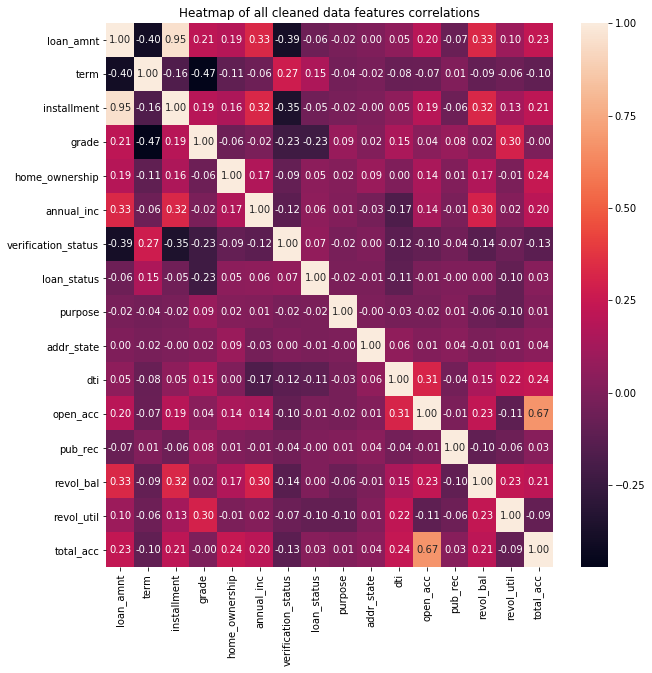

In [45]:
plt.figure(figsize=(10, 10))
sns.heatmap(updated_loans.corr(), annot=True, fmt=".2f")
plt.title("Heatmap of all cleaned data features correlations");
plt.show()

In [46]:
updated_loans.to_csv("data/cleaned_loan_data.csv",index=False)

### Section 5: Machine Learning Models

Two machine models are developed:<br>
**1. K-Nearest Neighbors (kNN) model**<br>
**2. Logistic Regression model**

Begin by defining features and target variable for the models. In this case, **target variable (y**) is the **loan status**. Features variables (X) are all columns in the cleaned dataset (excluding target variable).<br>
Then, split the data into train/test sets and look at data shape.

In [47]:
cleaned_data = pd.read_csv("data/cleaned_loan_data.csv")

X = cleaned_data.loc[:, cleaned_data.columns != "loan_status"]
y = cleaned_data.loc[:, "loan_status"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(194290, 16)
(48573, 16)
(194290,)
(48573,)


### KNN models
We will look at 3 different KNN models: 
1. KNN(n=1)
2. KNN(n=10)
3. KNN model with the best n value. 

**1. KNN (n=1) model.**<br>We see that KNN(n=1) model has a 72% accuracy of correctly identifying new loans as good or bad loans. Index for nearest neighbour of observations are also listed.

In [48]:
# instantiate the estimator
knn = KNeighborsClassifier(n_neighbors=1)

# fit the model
knn.fit(X_train, y_train)

# make a prediction
y_pred = knn.predict(X_test)
print("Prediction for KNN(n=1) model is: {}.".format(y_pred))

# model score
knn_score1 = metrics.accuracy_score(y_test, y_pred)
print("Accuracy score using KNN(n=1): %.2f%%" % (knn_score1 * 100.0))

# create 2 new observations and use these to make predictions with the model.
obs1 = np.array( [8000, 1, 180, 3, 7, 2, 45000, 2, 1, 10, 11.3, 5, 0, 6843, 35, 27])
obs1 = np.reshape(obs1, (1, -1))
obs2 = np.array([2600, 0, 190, 2, 4, 1, 27600, 3, 11, 5, 4, 6, 0, 1847.3, 23, 12.0])
obs2 = np.reshape(obs2, (1, -1))
print("The outcome prediction for 1st new loan observation using KNN(n=1) is: {}.".format(knn.predict(obs1)))
print("The nearest neighbor for 1st new loan observation using KNN(n=1) is at: {}.".format(knn.kneighbors(obs1)[1]))
print("The outcome prediction for 2nd new loan observation using KNN(n=1) is: {}.".format(knn.predict(obs2)))
print("The nearest neighbor for 2nd new loan observation using KNN(n=1) is at: {}.".format(knn.kneighbors(obs2)[1]))

Prediction for KNN(n=1) model is: [1 1 1 ... 1 1 0].
Accuracy score using KNN(n=1): 71.93%
The outcome prediction for 1st new loan observation using KNN(n=1) is: [1].
The nearest neighbor for 1st new loan observation using KNN(n=1) is at: [[73873]].
The outcome prediction for 2nd new loan observation using KNN(n=1) is: [1].
The nearest neighbor for 2nd new loan observation using KNN(n=1) is at: [[76083]].


**2. KNN (n=5) model**<br>We see that the KNN(n=15) model has a higher accuracy (80%) of predicting good and bad loans than KNN(n=1).<br>It also predicts both new loan observations as being good loans. 

In [49]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)
print("Prediction for KNN(n=10) model is: {}.".format(y_pred))
knn_score5 = metrics.accuracy_score(y_test, y_pred)
print("Accuracy score using KNN(n=10): %.2f%%" % (knn_score5 * 100.0))

# Use the same observations created above to make predictions for new loans using KNN(n=10) model.
print("The outcome prediction for first new loan observation using KNN(n=5) is: {}.".format(knn.predict(obs1)))
print("The 5 nearest neighbors for 1st new loan observation using KNN(n=5) are at: {}.".format(knn.kneighbors(obs1)[1]))
print("The outcome prediction for second new loan observation using KNN(n=5) is: {}.".format(knn.predict(obs2)))
print("The 5 nearest neighbors for 2nd new loan observation using KNN(n=5) are at: {}.".format(knn.kneighbors(obs2)[1]))

Prediction for KNN(n=10) model is: [1 1 1 ... 1 1 1].
Accuracy score using KNN(n=10): 79.68%
The outcome prediction for first new loan observation using KNN(n=5) is: [1].
The 5 nearest neighbors for 1st new loan observation using KNN(n=5) are at: [[ 73873  31070 184436 140641  51238]].
The outcome prediction for second new loan observation using KNN(n=5) is: [1].
The 5 nearest neighbors for 2nd new loan observation using KNN(n=5) are at: [[76083  9433 95894 48337 55575]].


#### Plot all accuracy scores for KNN models, for k values ranging from 1 to 15. Highest accuracy score is obtained when n=11.

Text(0, 0.5, 'Testing accuracy')

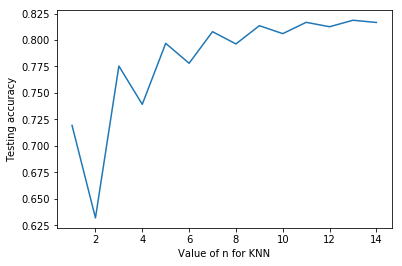

In [50]:
k_range = range(1, 15)
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    knn_score_total = metrics.accuracy_score(y_test, y_pred)
    scores.append(knn_score_total)

plt.plot(k_range, scores)
plt.xlabel("Value of n for KNN")
plt.ylabel("Testing accuracy")

**3. KNN (n=13) model**<br>Based of the graph above, highest accuracy is when n=13. We created a KNN (n=13) model and calculate its accuracy score. Predictions are also made using the same 2 new observations created above.<br>This model is a slightly higher accuracy rate (82%) than KNN(n=5), of correctly identifying whether new loans are good or bad. It also predicts both new observations are being good loans. 

In [51]:
knn = KNeighborsClassifier(n_neighbors=13)
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)
print("Prediction for KNN(n=13) model is: {}.".format(y_pred))
knn_score11 = metrics.accuracy_score(y_test, y_pred)
print("Accuracy score using KNN(n=13): %.2f%%" % (knn_score11 * 100.0))

# Use the same observations created above to make predictions for new loans using KNN(n=10) model.
print("The outcome prediction for first loan observation using KNN(n=13) is: {}.".format(knn.predict(obs1)))
print("The 13 nearest neighbors for 1st new loan observation using KNN(n=13) are at: {}.".format(knn.kneighbors(obs1)[1]))
print("The outcome prediction for second loan observation using KNN(n=13) is: {}.".format(knn.predict(obs2)))
print("The 13 nearest neighbors for 2nd new loan observation using KNN(n=13) are at: {}.".format(knn.kneighbors(obs2)[1]))

Prediction for KNN(n=13) model is: [1 1 1 ... 1 1 1].
Accuracy score using KNN(n=13): 81.87%
The outcome prediction for first loan observation using KNN(n=13) is: [1].
The 13 nearest neighbors for 1st new loan observation using KNN(n=13) are at: [[ 73873  31070 184436 140641  51238 175259 152393 163130  55189 113087
   16166  90304 154626]].
The outcome prediction for second loan observation using KNN(n=13) is: [1].
The 13 nearest neighbors for 2nd new loan observation using KNN(n=13) are at: [[ 76083   9433  95894  48337  55575  37384 169347 104327   5548 171788
   77367 114364  99656]].


In [52]:
# compare actual values to those predicted by the KNN(n=13) model.
df_knn = pd.DataFrame({"Actual": y_test, "Predicted": y_pred})
df_knn.sample(n=10)

,Actual,Predicted
136345,1,1
171981,0,1
91303,1,1
239178,0,1
207387,0,1
200801,1,1
242335,1,1
212192,1,1
192033,1,1
128531,0,1


**Confusion matrix for KNN model**<br>
From the figures below, we can see that this is a biased model. It has a very high sensitivity score, showing that it's able to predict good loans correctly 99% of the time. However, it is likely to predict bad loans correctly <2% of the time.<br>Model has a 18% chance of misclassifying loans as good or bad. Loans predicted as being good loans have approx 83% chance of being good loans.

In [53]:
cm = metrics.confusion_matrix(y_test, y_pred)
print("Confusion matrix for the KNN(n=11):")
print(cm)

TP = cm[1, 1]
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]

sensitivity = TP / float(TP + FN)
print("Sensitivity: %.2f%%" % (sensitivity * 100))

precision = TP / float(TP + FP)
print("Precision: %.2f%%" % (precision * 100))

error = (FP + FN) / (TP + TN + FP + FN)
print("Error: %.2f%%" % (error * 100))

specificity = TN / float(TN + FP)
print("Specificity: %.2f%%" % (specificity * 100))

Confusion matrix for the KNN(n=11):
[[  159  8374]
 [  434 39606]]
Sensitivity: 98.92%
Precision: 82.55%
Error: 18.13%
Specificity: 1.86%


**ROC curve and AUC score for KNN** <br>
From the close proximity of the ROC curve to the diagonal line and from the AUC score, it can be interpreted that test accuracy of this model is only a little better that chance.

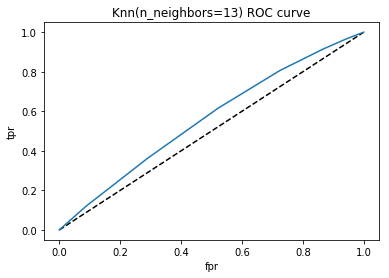

Area under curve score for KNN(n=13)model is: 56.16%


In [54]:
# ROC curve
y_pred_proba = knn.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='Knn')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('Knn(n_neighbors=13) ROC curve')
plt.show()

# Area under ROC curve
roc_knn = roc_auc_score(y_test,y_pred_proba)
print("Area under curve score for KNN(n=13)model is: %0.2f%%" % (roc_knn *100))

### Logistic Regression model
We see that the logistic regression model a marginally higher accuracy of making correct predictions of loan status,
compared to that of the KNN model with the best accuracy score (n=13). It also predicts both new loan observations as being good loans.

In [55]:
# instantiate logistic regression.
logreg = LogisticRegression()

# fit logistic regression model to the training set.
logreg.fit(X_train, y_train)

# to predict the test set results.
y_pred_class = logreg.predict(X_test)
print("Prediction for the logistic regression model is: {}".format(y_pred_class))

# model score
lm_accuracy = metrics.accuracy_score(y_test, y_pred_class)
print("Accuracy score using Logistic Regression: %.2f%%" % (lm_accuracy * 100.0))

# Use the same observations created above for KNN models to make predictions for new loans using the logreg model.
print("The outcome prediction for first loan observation using logreg model is: {}.".format(logreg.predict(obs1)))
print("The outcome prediction for second loan observation using logreg model is: {}.".format(logreg.predict(obs2)))

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Prediction for the logistic regression model is: [1 1 1 ... 1 1 1]
Accuracy score using Logistic Regression: 82.42%
The outcome prediction for first loan observation using logreg model is: [1].
The outcome prediction for second loan observation using logreg model is: [1].


In [56]:
# compare actual values to those predicted by the KNN(n=13) model.
df_log = pd.DataFrame({"Actual": y_test, "Predicted": y_pred_class})
df_log.sample(n=10)

,Actual,Predicted
100133,1,1
157867,1,1
145185,1,1
447,1,1
141109,1,1
214924,1,1
5926,0,1
101926,1,1
231544,1,1
166245,1,1


**Confusion matrix for logistic regression model**<br>
From the figures below, we can see that this is a biased model. It has a very high sensitivity score, showing that it's able to predict good loans correctly 99% of the time. However, it is likely to predict bad loans correctly <2% of the time.<br>Model has a 18% chance of misclassifying loans as good or bad. Loans predicted as being good loans have approx 83% chance of being good loans.

In [57]:
cm_log = metrics.confusion_matrix(y_test, y_pred_class)
print("Confusion matrix for Logistic Regression model:")
print(cm_log)

TP = cm_log[1, 1]
TN = cm_log[0, 0]
FP = cm_log[0, 1]
FN = cm_log[1, 0]

sensitivity = TP / float(TP + FN)
print("Sensitivity: %.2f%%" % (sensitivity * 100))

precision = TP / float(TP + FP)
print("Precision: %.2f%%" % (precision * 100))

error = (FP + FN) / (TP + TN + FP + FN)
print("Error: %.2f%%" % (error * 100))

specificity = TN / float(TN + FP)
print("Specificity: %.2f%%" % (specificity * 100))

Confusion matrix for Logistic Regression model:
[[    6  8527]
 [   12 40028]]
Sensitivity: 99.97%
Precision: 82.44%
Error: 17.58%
Specificity: 0.07%


**ROC curve and AUC score for logistic regression**<br>
Test accuracy of this model at 58.6%, is a little higher than that for KNN(n=13). The logistic regression model is the slightly better model of the two models.

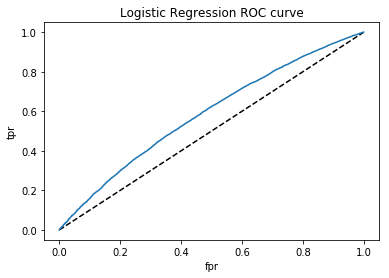

Area under curve score for logistic regression model is: 58.66%


In [58]:
# ROC curve
y_pred_proba_log = logreg.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_log)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='Logistic Regression')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('Logistic Regression ROC curve')
plt.show()

# Area under ROC curve
roc_log = roc_auc_score(y_test,y_pred_proba_log)
print("Area under curve score for logistic regression model is: %0.2f%%" % (roc_log *100))

In conclusion, the logistic regression is the better model to use between the two. 
Both models are not v. accurate classifiers and are biased towards predicting good loans. Future models could involve removing some of the poorly correlated features (as seen from the heatmap) to improve accuracy.